# Part 15

# Using Code Interpreter

Universal code for the entire notebook

In [2]:
# Uncomment the line below to make sure you have all the packages needed
# %pip install -r requirements.txt

In [3]:
# Import necessary libraries
from openai import OpenAI  # Used for interacting with OpenAI's API
from typing_extensions import override  # Used for overriding methods in subclasses
from openai import AssistantEventHandler  # Used for handling events related to OpenAI assistants
from IPython.display import display, Markdown, clear_output

import time
import threading

In [4]:
# Create an instance of the OpenAI class to interact with the API.
# This assumes you have set the OPENAI_API_KEY environment variable.
client = OpenAI() 

In [5]:
class EventHandler(AssistantEventHandler):
    """Custom event handler for processing assistant events."""

    def __init__(self):
        super().__init__()
        self.results = []  # Initialize the results list

    @override
    def on_text_created(self, text) -> None:
        """Handle the event when text is first created."""
        print("\nassistant text > ", end="", flush=True)
        self.results.append(text)

    @override
    def on_text_delta(self, delta, snapshot):
        """Handle the event when there is a text delta (partial text)."""
        print(delta.value, end="", flush=True)
        self.results.append(delta.value)

    def on_tool_call_created(self, tool_call):
        """Handle the event when a tool call is created."""
        print(f"\nassistant tool > {tool_call.type}\n", flush=True)

    def on_tool_call_delta(self, delta, snapshot):
        """Handle the event when there is a delta (update) in a tool call."""
        if delta.type == 'code_interpreter':
            if delta.code_interpreter.input:
                print(delta.code_interpreter.input, end="", flush=True)
                self.results.append(delta.code_interpreter.input)
            if delta.code_interpreter.outputs:
                print("\n\noutput >", flush=True)
                for output in delta.code_interpreter.outputs or []:  # Adding a safeguard
                    if output.type == "logs":
                        print(f"\n{output.logs}", flush=True)
                        self.results.append(output.logs)


## Creating an Assistant with Code Interpreter Enabled

Our first step is to create an Assistant that can use Code Interpreter

In [6]:
# Create an assistant using the client library.
assistant = client.beta.assistants.create(
    model="gpt-4o",  # Specify the model to be used.
    
    instructions=""" 
        You are a helpful assistant.
    """,
    
    name="Code Interpreter Assistant",  # Give the assistant a name.
    
    tools=[{"type": "code_interpreter"}], # Add the code interpreter capability to the assistant.
    
    metadata={  # Add metadata about the assistant's capabilities.
        "can_be_used_for_code_analysis": "True",
        "can_do_python": "True",
    },
    temperature=1,  # Set the temperature for response variability.
    top_p=1,  # Set the top_p for nucleus sampling.
)

# Print the details of the created assistant to check its properties.
print(assistant)  # Print the full assistant object.
print("\n\n")
print(assistant.name)  # Print the name of the assistant.
print(assistant.metadata)  # Print the metadata of the assistant.

Assistant(id='asst_58kps00XoHy4gSGHxFv5CZzN', created_at=1718813614, description=None, instructions=' \n        You are a helpful assistant.\n    ', metadata={'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}, model='gpt-4o', name='Code Interpreter Assistant', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), top_p=1.0)



Code Interpreter Assistant
{'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}


## Passing Files to Code Interpreter

There are a variety of ways to get files for Code Interpreter to use. 
- Assistant files - viewable by all runs that use the assistant.
- Thread files - only viewable by runs that use the thread. 

Let's review the code for the two main approaches.

### Getting Files to the Assistant

First, you have to have a file that has been uploaded so we can pass it to our assistant.

In [7]:
# Upload a file with an "assistants" purpose
assistant_file = client.files.create(
    file=open("./artifacts/penguins_size.csv", "rb"),
    purpose='assistants'
)

print(assistant_file)

FileObject(id='file-En7sSp5e4jJO6GS1pVZPm1o1', bytes=13519, created_at=1718813614, filename='penguins_size.csv', object='file', purpose='assistants', status='processed', status_details=None)


Next, we need to modify our Assistant with the new file information. 

In [8]:
assistant = client.beta.assistants.update(
    assistant_id=assistant.id,
    tools=[{"type": "code_interpreter"}],
    tool_resources={
        "code_interpreter": {
            "file_ids": [assistant_file.id]
        }
    }
)

print(assistant)

Assistant(id='asst_58kps00XoHy4gSGHxFv5CZzN', created_at=1718813614, description=None, instructions=' \n        You are a helpful assistant.\n    ', metadata={'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}, model='gpt-4o', name='Code Interpreter Assistant', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=['file-En7sSp5e4jJO6GS1pVZPm1o1']), file_search=None), top_p=1.0)


Finally, let's run a message and see if it is working.

In [9]:

# Your assistant code remains unchanged
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the file penguins_size.csv."
        },
    ]
)

with client.beta.threads.runs.stream(
    thread_id=assistant_thread.id,
    assistant_id=assistant.id,
    instructions="""
    You are a helpful assistant.
    """,
    event_handler=EventHandler(),
) as stream:
    stream.until_done()



assistant tool > code_interpreter

import pandas as pd

# Load the file
file_path = '/mnt/data/file-En7sSp5e4jJO6GS1pVZPm1o1'
penguins_data = pd.read_csv(file_path)

# Display the first few rows of the dataset and some summary statistics
penguins_data.head(), penguins_data.describe()
assistant text > The dataset **penguins_size.csv** contains information about penguins across different islands, with the following columns:

1. **species**: The species of the penguin (e.g., Adelie).
2. **island**: The island where the penguin was observed (e.g., Torgersen).
3. **culmen_length_mm**: The length of the culmen (the upper ridge of the bird's beak) in millimeters.
4. **culmen_depth_mm**: The depth of the culmen in millimeters.
5. **flipper_length_mm**: The length of the flipper in millimeters.
6. **body_mass_g**: The body mass of the penguin in grams.
7. **sex**: The sex of the penguin (e.g., MALE, FEMALE).

Here are some summary statistics for the numerical columns:

- **Culmen Length (mm)**

### Formatting the Output
What if we want to format the markdown output? There are two ways to do it. The "easy" way is to just let the output render without streaming and format it afterward.

In [21]:
# Need a thread to send message and get output
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the file penguins_size.csv."
        },
    ]
)

run = client.beta.threads.runs.create_and_poll(
    thread_id=assistant_thread.id, assistant_id=assistant.id
)

messages = list(client.beta.threads.messages.list(thread_id=assistant_thread.id, run_id=run.id))

message_content = messages[0].content[0].text
annotations = message_content.annotations
citations = []
for index, annotation in enumerate(annotations):
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    if file_citation := getattr(annotation, "file_citation", None):
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f"[{index}] {cited_file.filename}")

display(Markdown(message_content.value))

The file `penguins_size.csv` contains data about penguins and has the following characteristics:

- **Shape:** The dataset has 344 rows and 7 columns.
- **Columns:**
  1. `species`: The species of the penguins (e.g., Adelie).
  2. `island`: The island where the penguin was observed (e.g., Torgersen).
  3. `culmen_length_mm`: The length of the culmen (beak) in millimeters.
  4. `culmen_depth_mm`: The depth of the culmen in millimeters.
  5. `flipper_length_mm`: The length of the flipper in millimeters.
  6. `body_mass_g`: The body mass of the penguin in grams.
  7. `sex`: The sex of the penguin (e.g., MALE, FEMALE).

- **Data Information:**
  - There are missing values in the `culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`, and `sex` columns.
  - The data types of the columns are:
    - `species`, `island`, and `sex` are of type object (string).
    - `culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, and `body_mass_g` are of type float64.

- **First Few Rows of Data:**
  | species | island    | culmen_length_mm | culmen_depth_mm | flipper_length_mm | body_mass_g | sex   |
  |---------|-----------|------------------|-----------------|-------------------|-------------|-------|
  | Adelie  | Torgersen | 39.1             | 18.7            | 181.0             | 3750.0      | MALE  |
  | Adelie  | Torgersen | 39.5             | 17.4            | 186.0             | 3800.0      | FEMALE|
  | Adelie  | Torgersen | 40.3             | 18.0            | 195.0             | 3250.0      | FEMALE|
  | Adelie  | Torgersen | NaN              | NaN             | NaN               | NaN         | NaN   |
  | Adelie  | Torgersen | 36.7             | 19.3            | 193.0             | 3450.0      | FEMALE|

If you need any specific analysis or additional details, please let me know!

The "hard" way is to stream the output and update the display while streaming to show the formatted text. This is what ChatGPT does when you use it. This will require modifying our event handler to be more streamlined, formatting output, and updating our display.

In [11]:

class EventHandler(AssistantEventHandler):
    """Custom event handler for processing assistant events."""

    def __init__(self):
        super().__init__()
        self.results = []  # Initialize the results list

    @override
    def on_text_delta(self, delta, snapshot):
        """Handle the event when there is a text delta (partial text)."""
        self.results.append(delta.value)
        self.update_output()

    def update_output(self):
        """Update the Jupyter Notebook cell with the current markdown content."""
        clear_output(wait=True)
        markdown_content = "".join(self.results)
        display(Markdown(markdown_content))

# Your assistant code remains unchanged
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the file penguins_size.csv. With at least one small table of data. Make the information well formatted and easy to read."
        },
    ]
)

with client.beta.threads.runs.stream(
    thread_id=assistant_thread.id,
    assistant_id=assistant.id,
    instructions="""
    You are a helpful assistant.
    """,
    event_handler=EventHandler(),
) as stream:
    stream.until_done()


### Penguins Size Dataset Summary

The dataset contains various attributes measured from different penguin species. Below is a summary of the data:

#### Summary Statistics

| Attribute            | Count | Unique | Top      | Frequency | Mean    | Std Dev | Min    | 25%    | 50%    | 75%    | Max    |
|----------------------|-------|--------|----------|-----------|---------|---------|--------|--------|--------|--------|--------|
| **Species**          | 344   | 3      | Adelie   | 152       | -       | -       | -      | -      | -      | -      | -      |
| **Island**           | 344   | 3      | Biscoe   | 168       | -       | -       | -      | -      | -      | -      | -      |
| **Culmen Length (mm)** | 342   | -      | -        | -         | 43.92   | 5.46    | 32.10  | 39.23  | 44.45  | 48.50  | 59.60  |
| **Culmen Depth (mm)** | 342   | -      | -        | -         | 17.15   | 1.97    | 13.10  | 15.60  | 17.30  | 18.70  | 21.50  |
| **Flipper Length (mm)**| 342   | -      | -        | -         | 200.92  | 14.06   | 172.00 | 190.00 | 197.00 | 213.00 | 231.00 |
| **Body Mass (g)**    | 342   | -      | -        | -         | 4201.75 | 801.95  | 2700.00| 3550.00| 4050.00| 4750.00| 6300.00|
| **Sex**              | 334   | 3      | MALE     | 168       | -       | -       | -      | -      | -      | -      | -      |

#### Sample Data

Here is a small extract from the dataset:

| Species | Island | Culmen Length (mm) | Culmen Depth (mm) | Flipper Length (mm) | Body Mass (g) | Sex  |
|---------|--------|---------------------|--------------------|----------------------|---------------|------|
| Adelie  | Torgersen | 39.1               | 18.7               | 181                  | 3750          | MALE |
| Adelie  | Torgersen | 39.5               | 17.4               | 186                  | 3800          | FEMALE |
| Adelie  | Torgersen | 40.3               | 18.0               | 195                  | 3250          | FEMALE |
| Adelie  | Torgersen | NaN                | NaN                | NaN                  | NaN           | NaN |
| Adelie  | Torgersen | 36.7               | 19.3               | 193                  | 3450          | FEMALE |

This dataset provides a range of measurements for different penguin species found on islands. Each row corresponds to an individual penguin, featuring measurements such as culmen length, culmen depth, flipper length, body mass, and sex.

### Getting Files to the Thread

First, we need a file uploaded.


In [12]:
# Upload a file with an "assistants" purpose
thread_file = client.files.create(
    file=open("./artifacts/daily-bike-share.csv", "rb"),
    purpose='assistants'
)

print(thread_file)

FileObject(id='file-mXRW8eB92AjK2j2GEhYM3y7E', bytes=43599, created_at=1718813660, filename='daily-bike-share.csv', object='file', purpose='assistants', status='processed', status_details=None)


Second, we need a thread to attach the file to

In [13]:
thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the daily-bike-share.csv file."
        },
    ]
)

print(thread)

Thread(id='thread_RnCPF9DkyahJkvBFLiYs0t36', created_at=1718813661, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


Third, we can update the thread with the file information

In [14]:
updated_thread = client.beta.threads.update(
    thread_id=thread.id,
    tool_resources={
        "code_interpreter": {
            "file_ids": [thread_file.id]
        }
    }
)

print(updated_thread)

Thread(id='thread_RnCPF9DkyahJkvBFLiYs0t36', created_at=1718813661, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=['file-mXRW8eB92AjK2j2GEhYM3y7E']), file_search=None))


Finally, let's run it against a new assistant and see the results

In [15]:
# Create an assistant using the client library.
thread_assistant = client.beta.assistants.create(
    model="gpt-4o",  # Specify the model to be used.
    
    instructions=""" 
        You are a helpful assistant.
    """,
    
    name="Code Interpreter Assistant Using Thread Data",  # Give the assistant a name.
    
    tools=[{"type": "code_interpreter"}], # Add the code interpreter capability to the assistant.
    
    metadata={  # Add metadata about the assistant's capabilities.
        "can_be_used_for_code_analysis": "True",
        "can_do_python": "True",
    },
    temperature=1,  # Set the temperature for response variability.
    top_p=1,  # Set the top_p for nucleus sampling.
)

# Print the details of the created assistant to check its properties.
print(assistant)  # Print the full assistant object.
print("\n\n")
print(assistant.name)  # Print the name of the assistant.
print(assistant.metadata)  # Print the metadata of the assistant.

Assistant(id='asst_58kps00XoHy4gSGHxFv5CZzN', created_at=1718813614, description=None, instructions=' \n        You are a helpful assistant.\n    ', metadata={'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}, model='gpt-4o', name='Code Interpreter Assistant', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=['file-En7sSp5e4jJO6GS1pVZPm1o1']), file_search=None), top_p=1.0)



Code Interpreter Assistant
{'can_be_used_for_code_analysis': 'True', 'can_do_python': 'True'}


In [16]:
# stream the output from the assistant
with client.beta.threads.runs.stream(
    thread_id=updated_thread.id,
    assistant_id=thread_assistant.id,
    event_handler=EventHandler(),
) as stream:
    stream.until_done()

The dataset, `daily-bike-share.csv`, has 731 entries and 13 columns. Here's a brief summary of the dataset:

### Columns and Data Types:
1. **day**: integer (day of the month)
2. **mnth**: integer (month)
3. **year**: integer (year)
4. **season**: integer (season)
5. **holiday**: integer (whether the day is a holiday, 0: No, 1: Yes)
6. **weekday**: integer (day of the week, 0: Sunday to 6: Saturday)
7. **workingday**: integer (whether the day is a working day, 0: No, 1: Yes)
8. **weathersit**: integer (weather situation, 1: Clear, 2: Mist+Cloudy, 3: Light Snow+Light Rain, etc.)
9. **temp**: float (temperature, normalized)
10. **atemp**: float (feeling temperature, normalized)
11. **hum**: float (humidity, normalized)
12. **windspeed**: float (wind speed, normalized)
13. **rentals**: integer (number of bike rentals)

### Sample Data:
|   | day | mnth | year | season | holiday | weekday | workingday | weathersit |  temp  |  atemp |   hum   | windspeed | rentals |
|---|-----|------|------|--------|---------|---------|------------|------------|--------|--------|---------|-----------|---------|
| 0 | 1   | 1    | 2011 | 1      | 0       | 6       | 0          | 2          | 0.344  | 0.364  | 0.806   | 0.160     | 331     |
| 1 | 2   | 1    | 2011 | 1      | 0       | 0       | 0          | 2          | 0.363  | 0.354  | 0.696   | 0.249     | 131     |
| 2 | 3   | 1    | 2011 | 1      | 0       | 1       | 1          | 1          | 0.196  | 0.189  | 0.437   | 0.248     | 120     |
| 3 | 4   | 1    | 2011 | 1      | 0       | 2       | 1          | 1          | 0.200  | 0.212  | 0.590   | 0.160     | 108     |
| 4 | 5   | 1    | 2011 | 1      | 0       | 3       | 1          | 1          | 0.227  | 0.229  | 0.437   | 0.187     | 82      |

### Summary Statistics:
- **day**: Ranges from 1 to 31.
- **mnth**: Ranges from 1 to 12.
- **year**: Distributed equally between 2011 and 2012.
- **season**: Ranges from 1 to 4.
- **holiday**: Mostly 0 (non-holiday days), with few 1 (holiday days).
- **weekday**: Spread across 0 (Sunday) through 6 (Saturday).
- **workingday**: Majority of the data points are working days (1).
- **weathersit**: Mostly clear/mist/cloudy days, with a few rainy/snowy days.
- **temp**: Ranges from approximately 0.06 to 0.86.
- **atemp**: Ranges from approximately 0.07 to 0.84.
- **hum**: Ranges from 0 to about 0.97.
- **windspeed**: Ranges from about 0.02 to 0.51.
- **rentals**: Ranges from 2 to 3,410 bike rentals per day.

If you need further analysis or specific information regarding this dataset, feel free to ask!

### Text Results from files in Assistants and Threads

Let's see what happens if we use an assistant with a file and a thread with a file together

In [17]:
super_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a summary of the penguins-size.csv and daily-bike-share.csv files. Make the information well formatted and easy to read."
        },
    ]
)

print(super_thread)

Thread(id='thread_ei5VxprpMGDClH6hijZFP69m', created_at=1718813685, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


In [18]:
super_updated_thread = client.beta.threads.update(
    thread_id=super_thread.id,
    tool_resources={
        "code_interpreter": {
            "file_ids": [thread_file.id]
        }
    }
)

print(super_updated_thread)

Thread(id='thread_ei5VxprpMGDClH6hijZFP69m', created_at=1718813685, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=['file-mXRW8eB92AjK2j2GEhYM3y7E']), file_search=None))


In [19]:
# stream the output from the assistant
with client.beta.threads.runs.stream(
    thread_id=super_updated_thread.id,
    assistant_id=assistant.id,
    event_handler=EventHandler(),
) as stream:
    stream.until_done()

Let's start by loading and summarizing the contents of the files **penguins-size.csv** and **daily-bike-share.csv**. We'll extract key information such as column names, data types, any missing values, and some basic statistics. 

Let's begin with the **penguins-size.csv** file.### Summary of **penguins-size.csv**

**Column Information:**
- **species**: Object (Categorical)
- **island**: Object (Categorical)
- **culmen_length_mm**: Float64
- **culmen_depth_mm**: Float64
- **flipper_length_mm**: Float64
- **body_mass_g**: Float64
- **sex**: Object (Categorical)

**Missing Values:**
- **species**: 0
- **island**: 0
- **culmen_length_mm**: 2
- **culmen_depth_mm**: 2
- **flipper_length_mm**: 2
- **body_mass_g**: 2
- **sex**: 10

**Basic Statistics:**

| Statistic             | culmen_length_mm | culmen_depth_mm | flipper_length_mm | body_mass_g |
|-----------------------|------------------|-----------------|-------------------|-------------|
| **Count**             | 342              | 342             | 342               | 342         |
| **Mean**              | 43.92            | 17.15           | 200.92            | 4201.75     |
| **Standard Deviation**| 5.46             | 1.97            | 14.06             | 801.95      |
| **Minimum**           | 32.1             | 13.1            | 172.0             | 2700.0      |
| **25th Percentile**   | 39.23            | 15.6            | 190.0             | 3550.0      |
| **50th Percentile**   | 44.45            | 17.3            | 197.0             | 4050.0      |
| **75th Percentile**   | 48.5             | 18.7            | 213.0             | 4750.0      |
| **Maximum**           | 59.6             | 21.5            | 231.0             | 6300.0      |

Next, let's load and summarize the contents of the **daily-bike-share.csv** file.### Summary of **daily-bike-share.csv**

**Column Information:**
- **day**: Int64
- **mnth**: Int64
- **year**: Int64
- **season**: Int64
- **holiday**: Int64
- **weekday**: Int64
- **workingday**: Int64
- **weathersit**: Int64
- **temp**: Float64
- **atemp**: Float64
- **hum**: Float64
- **windspeed**: Float64
- **rentals**: Int64

**Missing Values:**
- **day**: 0
- **mnth**: 0
- **year**: 0
- **season**: 0
- **holiday**: 0
- **weekday**: 0
- **workingday**: 0
- **weathersit**: 0
- **temp**: 0
- **atemp**: 0
- **hum**: 0
- **windspeed**: 0
- **rentals**: 0

**Basic Statistics:**

| Statistic             | day   | mnth  | year  | season | holiday | weekday | workingday | weathersit | temp  | atemp | hum   | windspeed | rentals |
|-----------------------|-------|-------|-------|--------|---------|---------|------------|------------|-------|-------|-------|-----------|---------|
| **Count**             | 731.0 | 731.0 | 731.0 | 731.0  | 731.0   | 731.0   | 731.0      | 731.0      | 731.0 | 731.0 | 731.0 | 731.0     | 731.0   |
| **Mean**              | 15.74 | 6.52  | 2011.5| 2.50   | 0.03    | 3.00    | 0.68       | 1.40       | 0.50  | 0.47  | 0.63  | 0.19      | 848.18  |
| **Standard Deviation**| 8.81  | 3.45  | 0.50  | 1.11   | 0.17    | 2.00    | 0.47       | 0.54       | 0.18  | 0.16  | 0.14  | 0.08      | 686.62  |
| **Minimum**           | 1.0   | 1.0   | 2011.0| 1.0    | 0.0     | 0.0     | 0.0        | 1.0        | 0.06  | 0.08  | 0.00  | 0.02      | 2.0     |
| **25th Percentile**   | 8.0   | 4.0   | 2011.0| 2.0    | 0.0     | 1.0     | 0.0        | 1.0        | 0.34  | 0.34  | 0.52  | 0.13      | 315.5   |
| **50th Percentile**   | 16.0  | 7.0   | 2012.0| 3.0    | 0.0     | 3.0     | 1.0        | 1.0        | 0.50  | 0.49  | 0.63  | 0.18      | 713.0   |
| **75th Percentile**   | 23.0  | 10.0  | 2012.0| 3.0    | 0.0     | 5.0     | 1.0        | 2.0        | 0.66  | 0.61  | 0.73  | 0.23      | 1096.0  |
| **Maximum**           | 31.0  | 12.0  | 2012.0| 4.0    | 1.0     | 6.0     | 1.0        | 3.0        | 0.86  | 0.84  | 0.97  | 0.51      | 3410.0  |

Thus, both files have been summarized comprehensively with an analysis of their column names, data types, missing values, and basic descriptive statistics.

### Full Results Output

We may have other things that are produced

Image File ID: file-gVeNICAG4s7Hg596do5m6c5p


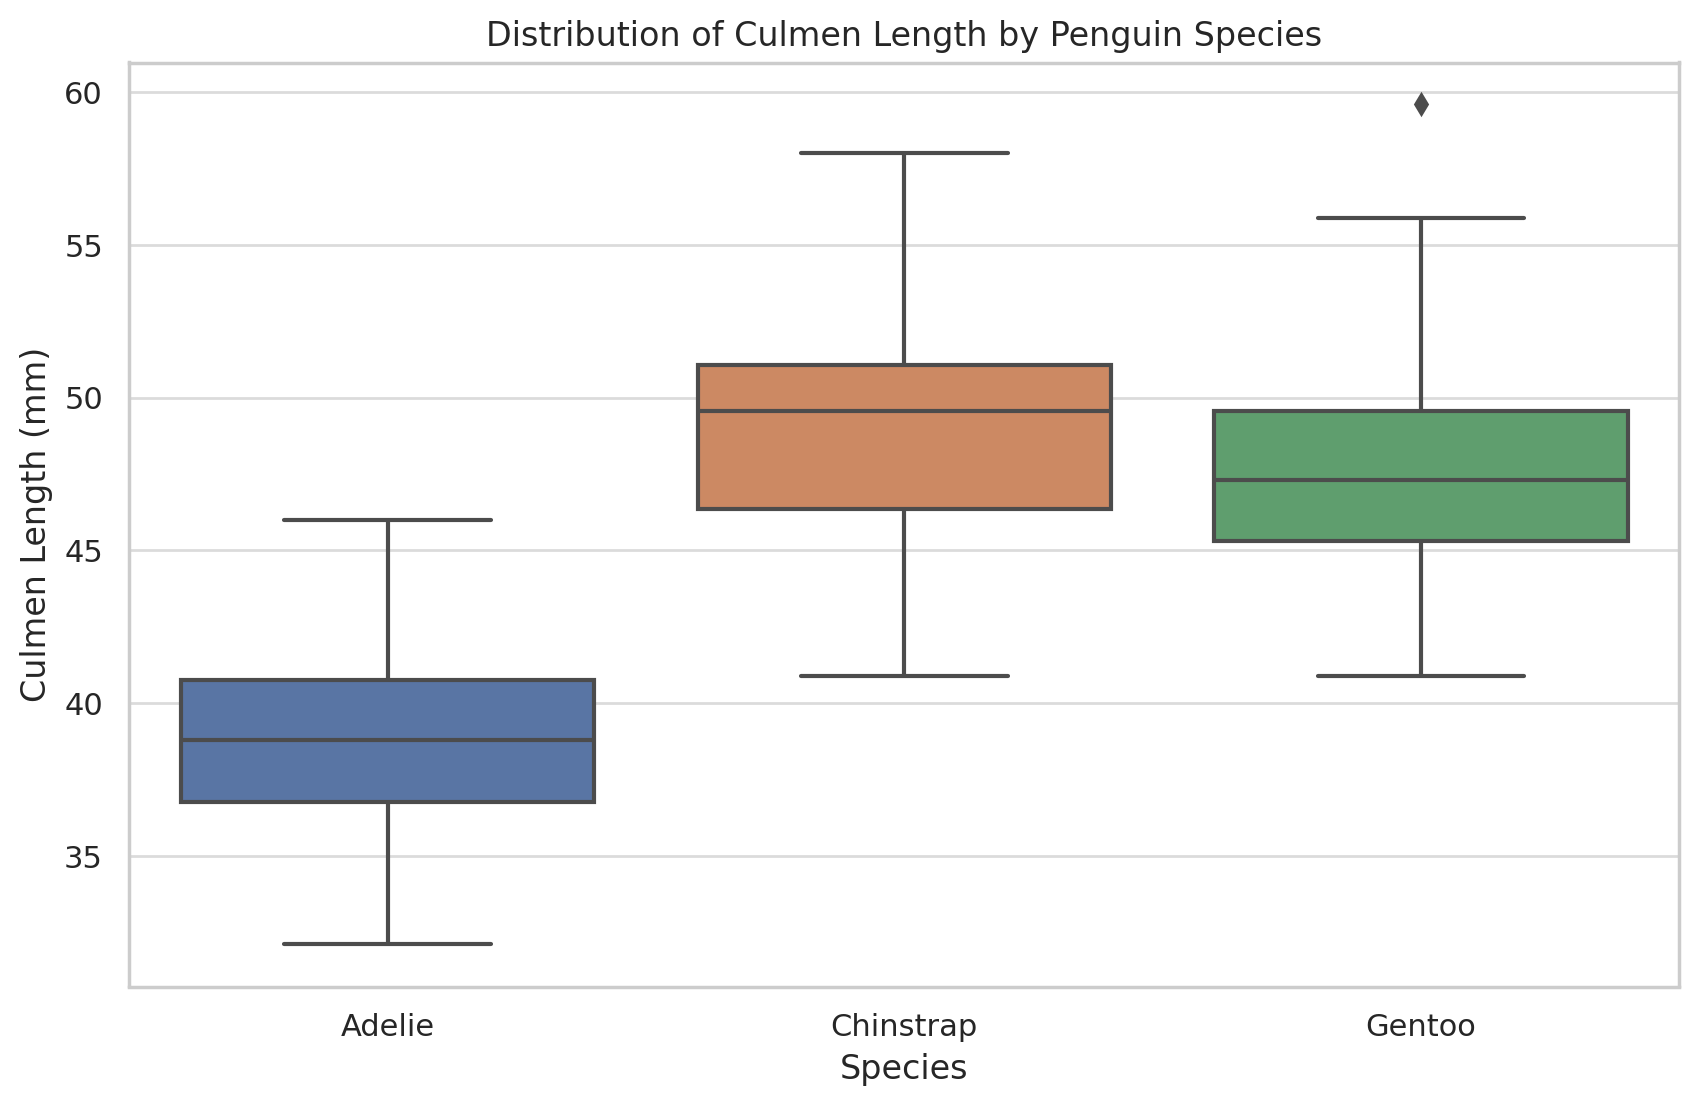

The dataset `penguins_size.csv` consists of various measurements of penguins across different species and islands. Each record includes the penguin's species, the island where it was found, culmen length and depth, flipper length, body mass, and sex. The dataset provides insights into the physical attributes of penguins from different species such as Adelie, Chinstrap, and Gentoo. The summary statistics are included, which show the mean and the distribution of these attributes.

Here is a summary of the culmen length distributions across the species:

| Species   | Mean Culmen Length (mm) |
|-----------|-------------------------|
| Adelie    | 39.425                  |
| Chinstrap | 48.833                  |
| Gentoo    | 47.504                  |

The following boxplot visualizes the distribution of culmen lengths for each species in the dataset:

![Distribution of Culmen Length by Penguin Species](attachment:boxplot_culmen_length.png)

The `penguins_size.csv` file contains data on pe

In [20]:
import requests
from IPython.display import display, Image

# Need a thread to send message and get output
assistant_thread = client.beta.threads.create(
    messages=[
        {
            "role": "user",
            "content": "Give me a one paragraph summary of the file penguins_size.csv. With at least one small table of data and one visualization."
        },
    ]
)

run = client.beta.threads.runs.create_and_poll(
    thread_id=assistant_thread.id, assistant_id=assistant.id
)

messages = list(client.beta.threads.messages.list(thread_id=assistant_thread.id, run_id=run.id))

# print(messages)
# print("\n\n")

for message in messages:
    for content_block in message.content:
        if content_block.type == 'text':
            text_content = content_block.text
            annotations = text_content.annotations
            citations = []
            for index, annotation in enumerate(annotations):
                # Replace the text with a footnote
                text_content.value = text_content.value.replace(annotation.text, f' [{index}]')
                # Gather citations based on annotation attributes
                if (file_citation := getattr(annotation, 'file_citation', None)):
                    cited_file = client.files.retrieve(file_citation.file_id)
                    citations.append(f'[{index}] {file_citation.quote} from {cited_file.filename}')
                elif (file_path := getattr(annotation, 'file_path', None)):
                    cited_file = client.files.retrieve(file_path.file_id)
                    citations.append(f'[{index}] Click <here> to download {cited_file.filename}')
                    # Note: File download functionality not implemented above for brevity
            # Add footnotes to the end of the message before displaying to user
            text_content.value += '\n' + '\n'.join(citations)
            print(text_content.value)

        elif content_block.type == 'image_file':
            image_file = content_block.image_file
            print(f"Image File ID: {image_file.file_id}")
            # Download and display the image
            file_info = client.files.retrieve(image_file.file_id)
            image_content = client.files.content(file_info.id)
            display(Image(image_content.content,width=700,height=700))
